# music reviews conditioned on songs

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

print('cuda.is_available:', torch.cuda.is_available())
print(f'available: {torch.cuda.device_count()}; current: {torch.cuda.current_device()}')
DEVICE = torch.device(f'cuda:{torch.cuda.current_device()}' if torch.cuda.is_available() else 'cpu')
print(DEVICE)
print('pytorch', torch.__version__)

cuda.is_available: True
available: 1; current: 0
cuda:0
pytorch 0.4.0


In [2]:
import pdb
from IPython.core.debugger import set_trace

## Data

In [3]:
import dill as pickle
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import spacy

BASE_DIR = os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, '..', 'datasets')

DATA_F = os.path.join(DATA_DIR, f'reviews_and_metadata_5yrs.json')
DATA_DF = pd.read_json(DATA_F)
len(DATA_DF)

37769

In [4]:
#DATA_DF.content[0]

In [5]:
# remove all double-quotation marks
#DATA_DF.content = DATA_DF.content.apply(lambda x: x.replace('"', ''))
#DATA_DF.content[0]

In [6]:
# remove reviews without audio features from Spotify
DATA_DF = DATA_DF.loc[~DATA_DF.audio_features.isna()]

In [7]:
DATA_DF = DATA_DF.assign(genres_str=lambda x: None)
DATA_DF.genres_str = DATA_DF.genres.apply(lambda x: '/'.join(x) if x is not None else 'none')

In [8]:
# filter out music with genre None or `non-music`
DATA_DF = DATA_DF.loc[(~DATA_DF.genres.isna()) & (~DATA_DF.genres_str.str.contains('non-music'))]

In [9]:
DATA_DF = DATA_DF.assign(energy=lambda x: None)
DATA_DF.energy = DATA_DF.audio_features.apply(lambda x: x['energy'])

In [11]:
SAMPLE_DF = DATA_DF.sample(15000)
#SAMPLE_DF = DATA_DF.sample(6) # overfit
TRAIN_DF, VAL_DF = train_test_split(SAMPLE_DF, test_size=0.2, random_state=42)
SAMPLE_DF.head()

#TRAIN_DF, VAL_DF = train_test_split(DATA_DF, test_size=0.2, random_state=42)

,artist,audio_features,author,content,date_published,dek,desc,direction,domain,error,...,post_title,posturl,rendered_pages,sitename,song_title,spotify_id,total_pages,word_count,genres_str,energy
9585,Foreign Air,"{'danceability': 0.579, 'energy': 0.584, 'key'...",Kristi shinfuku,Foreign Air isn't a group I'm too familiar wit...,2015-11-19T00:00:00.000Z,NaN,\n\n?\n\n,ltr,www.discobelle.net,NaN,...,Foreign Air- Free Animal,http://www.discobelle.net/2015/11/19/foreign-a...,1.0,Discobelle,Free Animal,5l8oNQsDDPNFUIV5M4lzRJ,1,82,pop,0.584
82,Basement Revolver,"{'danceability': 0.356, 'energy': 0.548, 'key'...",Tim,The Canadian sadcore trio Basement Revolver wi...,2018-05-19T00:00:00.000Z,NaN,\n\n?\n\n,ltr,emergingindiebands.com,NaN,...,Basement Revolver – Baby – Audio,https://emergingindiebands.com/basement-revolv...,1.0,Emerging Indie Bands,Baby,3ZbHj5xFNsxwItdCJ7k3dL,1,156,pop,0.548
7011,Golden Coast,"{'danceability': 0.762, 'energy': 0.8320000000...",Oblivious Pop,"Golden Coast are back this week, and like alwa...",2018-06-20T08:13:00.000Z,NaN,\n\n?\n\n,ltr,www.obliviouspop.com,NaN,...,Recess,http://www.obliviouspop.com/2016/08/golden-coa...,1.0,Oblivious Pop,Recess,5BB6riskdmhOajkh4VCkJw,1,74,pop,0.832
32314,Elder Island,"{'danceability': 0.919, 'energy': 0.44, 'key':...",None,Elder Island | The Big Unknown\nby Tom Johnso...,2014-06-13T10:11:29.000Z,NaN,\n\n?\n\n,ltr,www.goldflakepaint.co.uk,NaN,...,Fresh Licks | Elder Island ~ The Big Unknown,http://www.goldflakepaint.co.uk/fresh-licks-el...,1.0,Gold Flake Paint,The Big Unknown,2yMR0hZZk0oBw2XBvhQTSF,1,137,pop,0.440
10351,MEG MAC,"{'danceability': 0.5720000000000001, 'energy':...",None,Fresh from stomping all over the USA with D'An...,None,NaN,\n\n?\n\n,ltr,pilerats.com,NaN,...,Listen: Meg Mac - Never Be,http://pilerats.com/music/bands/listen-meg-mac...,1.0,Pilerats,Never Be,1qSSbzRFLoYvRywhCWk1K9,1,264,r-b,0.592


In [12]:
SAMPLE_DF.groupby('genres_str').size().sort_values(ascending=False)
#DATA_DF.groupby('genres_str').size().sort_values(ascending=False)

genres_str
pop                                   7233
rap                                   1692
rock                                  1649
non-music                             1440
none                                  1099
r-b                                    717
rock/pop                               317
r-b/pop                                280
rap/r-b                                178
rap/pop                                 86
rap/rock/country/r-b/pop                59
rap/r-b/pop                             42
non-music/rap/rock/country/r-b/pop      32
non-music/rap                           29
country                                 27
non-music/pop                           26
rock/r-b                                22
rap/rock                                11
non-music/rap/rock/pop                  10
non-music/rock                          10
rap/rock/country/pop                     7
rock/r-b/pop                             6
rock/country                             5


**TODO**: `non-music` genre means what in this context?

**NOTE**: `pop` dominates genres

## LM data

In [13]:
#!python -m spacy download en
spacy_tok = spacy.load('en')

In [14]:
BPTT = 70           # like the 'n' in n-gram, or order
BS = 64             # batch size
N_EMB = 300         # size of embedding vector
N_HIDDEN = 1024     # size of hidden activations per layer
N_LAYERS = 2        # number of stacked RNNs
MIN_FREQ = 1 #3        # min frequency of token for it to not be <unk>

In [15]:
from torchtext import vocab, data

from fastai.nlp import *
from fastai.lm_rnn import *

TEXT = data.Field(lower=True, tokenize='spacy')

md = LanguageModelData.from_dataframes('.', TEXT, 'content', TRAIN_DF, VAL_DF, bs=BS, bptt=BPTT, min_freq=MIN_FREQ)

len(md.trn_dl), md.nt, len(md.trn_ds), len(md.trn_ds[0].text)

(483, 47982, 1, 2170269)

In [16]:
len(TRAIN_DF), len(VAL_DF)

(12000, 3000)

_Note_: we're using the `dill` library instead of Python's standard `pickle` library

In [17]:
#MODEL_DIR = os.path.join(DATA_DIR, 'models')
#if not os.path.exists(MODEL_DIR):
#    os.mkdir(MODEL_DIR)
    
#pickle.dump(TEXT, open(os.path.join(MODEL_DIR, 'TEXT.pkl'), 'wb'))

In [18]:
TEXT.vocab.itos[:12]

['<unk>', '<pad>', '\n', ',', 'the', '.', 'and', '"', 'a', 'of', 'to', '-']

In [19]:
TEXT.vocab.stoi['and']

6

In [20]:
print(md.trn_ds[0].text[:12])
print(TEXT.numericalize([md.trn_ds[0].text[:12]]))

['<bos>', 'can', 'the', 'world', 'please', 'start', 'acknowledging', 'the', 'glory', 'of', 'powers', '?']
tensor([[    24],
        [    69],
        [     4],
        [   186],
        [   617],
        [   392],
        [ 14151],
        [     4],
        [  3173],
        [     9],
        [  2257],
        [    77]], device='cuda:0')


## reviews without conditioning

In [21]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, hidden_size, n_emb, batch_size, num_layers):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.vocab_size = vocab_size
        
        self.embedding = nn.Embedding(vocab_size, n_emb)
        self.rnn = nn.LSTM(n_emb, hidden_size, num_layers, dropout=0.5)
        self.l_out = nn.Linear(hidden_size, vocab_size)
        self.softmax = nn.LogSoftmax(dim=-1)
        
        self.init_hidden(batch_size)
        
    def forward(self, inputs):
        bs = inputs[0].size(0)
        if self.hidden[0].size(1) != bs: self.init_hidden(bs)
            
        inputs = self.embedding(inputs)
        output, hidden = self.rnn(inputs, self.hidden)
        self.hidden = [h.detach() for h in hidden]
        output = self.l_out(output)
        output = self.softmax(output)
        
        return output.view(-1, self.vocab_size)
    
    def init_hidden(self, bs):
        self.batch_size = bs
        self.hidden = (V(torch.zeros(self.num_layers, self.batch_size, self.hidden_size)),
                  V(torch.zeros(self.num_layers, self.batch_size, self.hidden_size)))

In [22]:
def sample_fast(model, seed='<bos>', sample=True):
    idxs = TEXT.numericalize([[tok.text for tok in spacy_tok(seed)]])
    p = model(VV(idxs.transpose(0,1)))
    if sample:
        r = torch.multinomial(p[-1].exp(), 1)
        return TEXT.vocab.itos[to_np(r)[0]]
    
    r = p[-1].topk(1)[1][0]
    return TEXT.vocab.itos[r.item()]

def sample_fast_n(model, n, seed='<bos>', sample=True, return_res=False):
    res = '' if seed == '<bos>' else seed + ' '
    for i in range(n):
        w = sample_fast(model, seed, sample)
        res += w + ' '
        seed = seed[1:] + w
    if return_res:
        return res
    else:
        print(res)

In [23]:
# Note: check BPTT value if fit throw "ZeroDivisionError: Weights sum to zero, can't be normalized"
# in validate method of fastai/model.py

lstm = LSTM(md.nt, N_HIDDEN, N_EMB, BS, N_LAYERS).to(DEVICE)
lo = LayerOptimizer(optim.Adam, lstm, 1e-4, 1e-6)

losses = []
for i in range(5):
    cb = [CosAnneal(lo, len(md.trn_dl), cycle_mult=2)]
    losses.append(fit(lstm, md, 10, lo.opt, F.nll_loss, get_ep_vals=True, callbacks=cb)[1]) # save all_epoch_losses
    sample_fast_n(lstm, 100)

epoch      trn_loss   val_loss                              
    0      6.754142   6.745746  
    1      6.459741   6.433272                              
    2      6.330723   6.353769                              
    3      6.072072   6.056607                              
    4      5.872627   5.888852                              
    5      5.782148   5.818115                              
    6      5.757516   5.8083                                
    7      5.648123   5.667569                              
    8      5.510018   5.550758                              
    9      5.405547   5.466751                              

towards srry gullivers sense pique ding njena koyote simone objectifying caught wicklow y'a afterwards centennial warrants stream unknowingly vilde lou greats red 7 
 awkwardly frail handclaps excentricies mounts giveaway imprivising swimmingly wow'ed choruses maco mcquaid cosores progenitors pinkprint esquite bops remix claires arp fatima first_name"]= 

epoch      trn_loss   val_loss                              
    0      5.340128   5.425382  
    1      5.301316   5.377192                              
    2      5.262013   5.36159                               
    3      5.230847   5.319402                              
    4      5.17532    5.276278                              
    5      5.144127   5.253846                              
    6      5.119876   5.250424                              
    7      5.097381   5.220055                              
    8      5.037984   5.176056                              
    9      4.987005   5.141932                              

innanetape dockvilleaugust richest justlne nancy keiynan aeroplanes bitchin reggie 02.21.14 dive fredo harnesses nat initially forward- oz hhh fuera dba schnabel blanck titties zany canada fest raleigh this skrillex have day 
 stylizing employed shambhala djembe lid grimy cristiano early players www.facebook.com/kaytranada scoff looses fidgety trade punc

epoch      trn_loss   val_loss                              
    0      4.948722   5.124251  
    1      4.94001    5.105685                              
    2      4.91483    5.097465                              
    3      4.907358   5.081289                              
    4      4.87984    5.062583                              
    5      4.849221   5.051855                              
    6      4.839679   5.050666                              
    7      4.841165   5.038066                              
    8      4.806737   5.017091                              
    9      4.777346   4.998975                              

turnt mathematicians ledsham hmm d1 relates useless clearer javid sumol booooooom whooping shining @raury tracks/232629885&color stainless ashby tasmania heppell 12/3 de continuum brett cinemas lincoln vogue wonder tapestry 3 and fm4 interlude oak joiners hold twenty beat jaymes 
 iskwe cigar symbolism pare pecknold countrymen chomeo fenech uploads/2014/

epoch      trn_loss   val_loss                              
    0      4.751172   4.989503  
    1      4.746474   4.979346                              
    2      4.734279   4.976912                              
    3      4.732709   4.968177                              
    4      4.709341   4.958548                              
    5      4.693945   4.953138                              
    6      4.687394   4.952815                              
    7      4.692812   4.943118                              
    8      4.66914    4.933413                              
    9      4.653155   4.924559                              

wobble woodson neuer flirting show unaware monks berlin killera jarvis 5/9 sligo thief 11/06/2014 surfeit ignition 10/31 claps robotics luxe simplify churned whelan greene topanga encore obscene weaker- heroic fulfilling croft richman params="color hippolytus coome enrapturing cuteass send divorce iskra mish bailes masonic trade22 dad fela specific https

epoch      trn_loss   val_loss                              
    0      4.635088   4.918423  
    1      4.6368     4.911965                              
    2      4.620965   4.91068                               
    3      4.628355   4.907084                              
    4      4.646193   4.898926                              
    5      4.600435   4.896958                              
    6      4.596992   4.896909                              
    7      4.605529   4.890996                              
    8      4.599737   4.886075                              
    9      4.571962   4.879039                              

catford refraction underestimated ninjas twilights fan- repute karra 9-track frst gorgs bios technique bloodboy parka venice tagsreal screams devotee suey nuisance amplifiers sultry unicron raz bachman energia jambolaya savourer dreadful misogynists safari driftless triangel recess parachutes humorous aviv corne july15 electroacoustic torontonians miscom

In [24]:
def plot_loss(losses):
    epochs = []
    trn_loss = []
    val_loss = []
    
    for i, loss_group in enumerate(losses):
        epochs.extend([(len(loss_group)*i) + epoch[0] + 1 for epoch in loss_group.items()])
        trn_loss.extend([epoch[1][0] for epoch in loss_group.items()])
        val_loss.extend([epoch[1][1] for epoch in loss_group.items()])

    %matplotlib inline
    plt.clf()
    plt.figure()
    plt.plot(epochs, trn_loss)
    plt.plot(epochs, val_loss)
    
    import math
    print(f'Perplexity: {math.exp(losses[-1][len(losses[-1])-1][1])}')

"Language modeling accuracy is generally measured using the metric _perplexity_, which is simply exp() of the loss function we used [*cross_entropy*]."

Perplexity: 131.5042275802113


<Figure size 432x288 with 0 Axes>

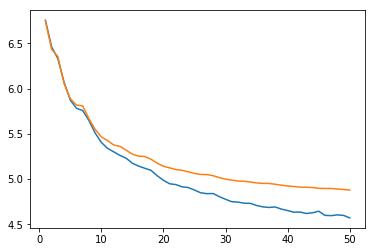

In [25]:
plot_loss(losses)

In [26]:
for i in range(1):
    cb = [CosAnneal(lo, len(md.trn_dl), cycle_mult=2)]
    losses.append(fit(lstm, md, 10, lo.opt, F.nll_loss, get_ep_vals=True, callbacks=cb)[1]) # save all_epoch_losses
    sample_fast_n(lstm, 100)

epoch      trn_loss   val_loss                              
    0      4.563702   4.875303  
    1      4.584873   4.871598                              
    2      4.555562   4.87269                               
    3      4.557245   4.867405                              
    4      4.547336   4.864909                              
    5      4.540615   4.863772                              
    6      4.535823   4.862855                              
    7      4.548561   4.861501                              
    8      4.531875   4.855865                              
    9      4.520798   4.853434                              

emotes kutless07 foregoing bancamp bending drawing maximiliaan boyle f*cking ajimal endorphins specification stereo16 ardentes wfmo werchter smells chiseled 08/09 valmadre garrison slowburning run nucleus bottleneck betoko pensive rejuvenated sleeve tivoli4 ambulance glasgow22 weeknd p.t.s.d. wildheart debunks singe friend israel samplers deetron sleeper

Perplexity: 128.17980438771724


<Figure size 432x288 with 0 Axes>

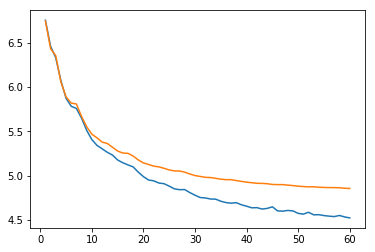

In [27]:
plot_loss(losses)

### AWD-LSTM

from https://github.com/fastai/fastai/blob/master/courses/dl1/lesson4-imdb.ipynb:

>Researchers have found that large amounts of momentum (which we'll learn about later) don't work well with these kinds of RNN models, so we create a version of the Adam optimizer with less momentum than it's default of 0.9.

>fastai uses a variant of the state of the art AWD LSTM Language Model developed by Stephen Merity. A key feature of this model is that it provides excellent regularization through Dropout.

In [28]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))
awd_learner = md.get_model(opt_fn, N_EMB, N_HIDDEN, N_LAYERS - 1)
awd_learner.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
awd_learner.clip=0.3

from https://medium.com/@hiromi_suenaga/deep-learning-2-part-1-lesson-1-602f73869197:

`lr_find()` helps you find an optimal learning rate. It uses the technique developed in the 2015 paper [Cyclical Learning Rates for Training Neural Networks](http://arxiv.org/abs/1506.01186), where we simply keep increasing the learning rate from a very small value, until the loss stops decreasing. We can plot the learning rate across batches to see what this looks like.

 92%|█████████▏| 442/483 [00:46<00:04,  9.41it/s, loss=26.1]

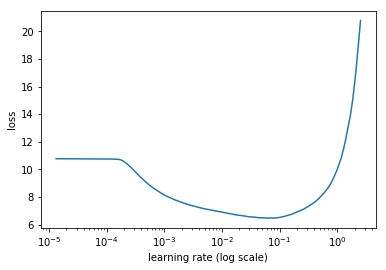

In [29]:
awd_learner.lr_find()
awd_learner.sched.plot()

Looks like the loss is still somewhat clearly improving at learning rate
- n_reviews = 5K => `1e-3` (0.001)
- n_reviews = 15K => `5e-4` (0.0005)

In [31]:
def sample_awd(model, seed='<bos>', sample=True):
    idxs = TEXT.numericalize([[tok.text for tok in spacy_tok(seed)]])
    p = model(VV(idxs.transpose(0,1)))[0]
    if sample:
        r = torch.multinomial(p[-1].exp(), 1)
        return TEXT.vocab.itos[to_np(r)[0]]
    
    r = p[-1].topk(1)[1][0]
    return TEXT.vocab.itos[r.item()]

def sample_awd_n(model, n, seed='<bos>', sample=True, return_res=False):
    res = '' if seed == '<bos>' else seed + ' '
    for i in range(n):
        w = sample_awd(model, seed, sample)
        res += w + ' '
        seed = seed[1:] + w
    if return_res:
        return res
    else:
        print(res)

In [32]:
losses = []
for i in range(5):
    losses.append(awd_learner.fit(5e-4, 4, wds=1e-6, cycle_len=1, cycle_mult=2, get_ep_vals=True)[1]) # save all_epoch_losses
    sample_awd_n(awd_learner.model, 100)

epoch      trn_loss   val_loss                              
    0      6.650654   6.592561  
    1      6.336328   6.207628                              
    2      6.223507   6.114243                              
    3      6.005602   5.824192                              
    4      5.864571   5.677913                              
    5      5.798437   5.62076                               
    6      5.78725    5.607812                              
    7      5.701596   5.479992                              
    8      5.606392   5.380626                              
    9      5.540321   5.310851                              
    10     5.486511   5.258359                              
    11     5.4538     5.226913                              
    12     5.434755   5.212326                              
    13     5.429241   5.203448                              
    14     5.425101   5.203626                              
ground sodwee.com stronger club bette bff of guitar-

epoch      trn_loss   val_loss                              
    0      5.445175   5.190042  
    1      5.419447   5.14291                               
    2      5.370512   5.126523                              
    3      5.366784   5.092046                              
    4      5.31007    5.054382                              
    5      5.292071   5.031411                              
    6      5.282657   5.026094                              
    7      5.280525   4.994841                              
    8      5.252575   4.960882                              
    9      5.206398   4.928049                              
    10     5.17304    4.909397                              
    11     5.171621   4.899291                              
    12     5.15793    4.89069                               
    13     5.142938   4.887303                              
    14     5.167408   4.885898                              
dabadaba <eos> nz cogitative heart- scathed , https:

epoch      trn_loss   val_loss                              
    0      5.189122   4.892474  
    1      5.187481   4.875282                              
    2      5.16086    4.864828                              
    3      5.158444   4.84725                               
    4      5.128775   4.830208                              
    5      5.115503   4.817781                              
    6      5.119772   4.815069                              
    7      5.116996   4.803435                              
    8      5.084499   4.782673                              
    9      5.089919   4.769409                              
    10     5.060301   4.75745                               
    11     5.041272   4.751005                              
    12     5.040506   4.744415                              
    13     5.019109   4.741584                              
    14     5.018279   4.740154                              
caramel <eos> buchla whomping teatria monsieur burro

epoch      trn_loss   val_loss                              
    0      5.063756   4.752997  
 13%|█▎        | 61/483 [00:06<00:43,  9.72it/s, loss=5.04]

KeyboardInterrupt: 

Perplexity: 114.4518259042479


<Figure size 432x288 with 0 Axes>

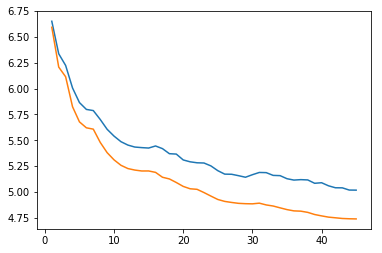

In [33]:
plot_loss(losses)

## reviews conditioned on genre

**TODO**: what to do about `none` or `non-music` genres?

### genre tensor

In [36]:
ALL_GENRES = list(set([genre.upper() for list_genres in SAMPLE_DF.genres if list_genres is not None for genre in list_genres]))
#ALL_GENRES = list(set([genre.upper() for list_genres in DATA_DF.genres if list_genres is not None for genre in list_genres]))
N_GENRES = len(ALL_GENRES)
print(f'unique genres ({N_GENRES}): {ALL_GENRES}')

unique genres (6): ['R-B', 'RAP', 'NON-MUSIC', 'POP', 'COUNTRY', 'ROCK']


In [37]:
# one-hot tensor for genres
def one_hot_genre(genres):
    enc = torch.zeros(1, N_GENRES)
    if genres is None:
        return enc
    if isinstance(genres, torch.Tensor):
        return genres
    
    for genre in genres:
        genre_idx = ALL_GENRES.index(genre.upper())
        enc[0][genre_idx] = 1

    return enc

print('r-b tensor:', one_hot_genre(['r-b', 'rap']))

r-b tensor: tensor([[ 1.,  1.,  0.,  0.,  0.,  0.]])


In [38]:
def sample_fast_genre(model, seed='<bos>', genres=['r-b'], sample=True):
    tokenized_text = [tok.text for tok in spacy_tok(seed)]
    text_tensor = TEXT.numericalize([tokenized_text])
    genre_tensor = torch.stack([one_hot_genre(genres)] * len(tokenized_text))
    p = model(VV(text_tensor.transpose(0,1)), VV(genre_tensor.transpose(0,1)))
    if sample:
        r = torch.multinomial(p[-1].exp(), 1)
        return TEXT.vocab.itos[to_np(r)[0]]
    
    r = p[-1].topk(1)[1][0]
    return TEXT.vocab.itos[r.item()]

def sample_fast_genre_n(model, n, seed='<bos>', genres=['r-b'], sample=True, return_res=False):
    res = '' if seed == '<bos>' else seed + ' '
    for i in range(n):
        w = sample_fast_genre(model, seed, genres, sample)
        res += w + ' '
        seed = seed[1:]+w
    if return_res:
        return res
    else:
        print(res)

### adding genre to languagemodelloader

let's look at the current training data...

In [39]:
#md.trn_dl.data

In [40]:
list(zip(md.trn_ds[0].text[:20], TEXT.numericalize([md.trn_ds[0].text[:20]])))

[('<bos>', tensor([ 24], device='cuda:0')),
 ('can', tensor([ 69], device='cuda:0')),
 ('the', tensor([ 4], device='cuda:0')),
 ('world', tensor([ 186], device='cuda:0')),
 ('please', tensor([ 617], device='cuda:0')),
 ('start', tensor([ 392], device='cuda:0')),
 ('acknowledging', tensor([ 14151], device='cuda:0')),
 ('the', tensor([ 4], device='cuda:0')),
 ('glory', tensor([ 3173], device='cuda:0')),
 ('of', tensor([ 9], device='cuda:0')),
 ('powers', tensor([ 2257], device='cuda:0')),
 ('?', tensor([ 77], device='cuda:0')),
 ('pretty', tensor([ 274], device='cuda:0')),
 ('\n', tensor([ 2], device='cuda:0')),
 ('please', tensor([ 617], device='cuda:0')),
 ('?', tensor([ 77], device='cuda:0')),
 ('the', tensor([ 4], device='cuda:0')),
 ('la', tensor([ 241], device='cuda:0')),
 ('duo', tensor([ 125], device='cuda:0')),
 ('have', tensor([ 48], device='cuda:0'))]

TorchText allows `Dataset`s with multiple `Field`s.

Sadly, `fastai.nlp.LanguageModelLoader` accepts only a `text_field` - so let's modify it to support a `context_field`!

In [41]:
# modified from: https://github.com/fastai/fastai/blob/master/fastai/nlp.py

class ConcatTextAndContextDatasetFromDataFrames(torchtext.data.Dataset):
    # TODO: support multiple context columns?
    def __init__(self, df, text_field, text_col, context_field, context_col, newline_eos=True, **kwargs):
        fields = [('text', text_field), ('context', context_field)]
        text = []
        
        context_multiples = []
        texts = [text_field.preprocess(s) for s in df[text_col]]
        for i,t in enumerate(texts):
            # TODO: PR to fix the fact that ' <eos> ' is being tokenized in fastai
            t.append('<eos>')
            t.insert(0, '<bos>')
            text += t
            context_multiples.extend([list(df[context_col])[i]] * len(t))
        
        context = context_field.preprocess(context_multiples)

        examples = [torchtext.data.Example.fromlist([text, context], fields)]

        super().__init__(examples, fields, **kwargs)

    @classmethod
    def splits(cls, train_df=None, val_df=None, test_df=None, keep_nones=False, **kwargs):
        res = (
            cls(train_df, **kwargs),
            cls(val_df, **kwargs),
            map_none(test_df, partial(cls, **kwargs)))  # not required
        return res if keep_nones else tuple(d for d in res if d is not None)

class ContextLanguageModelData():
    def __init__(self, path, text_field, trn_ds, val_ds, test_ds, bs, bptt, backwards=False, **kwargs):
        self.bs = bs
        self.path = path
        self.trn_ds = trn_ds; self.val_ds = val_ds; self.test_ds = test_ds
        if not hasattr(text_field, 'vocab'): text_field.build_vocab(self.trn_ds, **kwargs)

        self.pad_idx = text_field.vocab.stoi[text_field.pad_token]
        self.nt = len(text_field.vocab)

        factory = lambda ds: ContextLanguageModelLoader(ds, bs, bptt, backwards=backwards, **kwargs)
        self.trn_dl = factory(self.trn_ds)
        self.val_dl = factory(self.val_ds)
        self.test_dl = map_none(self.test_ds, factory)  # not required

    def get_model(self, opt_fn, emb_sz, n_hid, n_layers, **kwargs):
        m = get_language_model(self.nt, emb_sz, n_hid, n_layers, self.pad_idx, **kwargs)
        model = SingleModel(to_gpu(m))
        return RNN_Learner(self, model, opt_fn=opt_fn)

    @classmethod
    def from_dataframes(cls, path, text_field, text_col, context_field, context_col, train_df, val_df, test_df=None, bs=64, bptt=70, **kwargs):
        trn_ds, val_ds, test_ds = ConcatTextAndContextDatasetFromDataFrames.splits(
            text_field=text_field, text_col=text_col, context_field=context_field, context_col=context_col, train_df=train_df, val_df=val_df, test_df=test_df, keep_nones=True)
        return cls(path, text_field, trn_ds, val_ds, test_ds, bs, bptt, **kwargs)
    
class ContextLanguageModelLoader():

    def __init__(self, ds, bs, bptt, backwards=False, **kwargs):
        self.bs,self.bptt,self.backwards = bs,bptt,backwards
        
        bs_rank_three = kwargs.pop('bs_rank_three', None)
        
        text = sum([o.text for o in ds], [])
        text_fld = ds.fields['text']
        
        # TODO: any number of extra Fields?
        #context = torch.stack([oneHotGenre(c) for o in ds for c in o.context])
        context = torch.stack([c for o in ds for c in o.context])
        text_nums = text_fld.numericalize([text], device=None if torch.cuda.is_available() else -1)
        
        self.text_data = self.batchify(text_nums)
        self.context_data = self.batchify(context, bs_rank_three)
        
        self.i,self.iter = 0,0
        self.n = len(self.text_data)

    def __iter__(self):
        self.i,self.iter = 0,0
        return self

    def __len__(self): return self.n // self.bptt - 1

    def __next__(self):
        if self.i >= self.n-1 or self.iter>=len(self): raise StopIteration
        bptt = self.bptt if np.random.random() < 0.95 else self.bptt / 2.
        seq_len = max(5, int(np.random.normal(bptt, 5)))
        res = self.get_batch(self.i, seq_len)
        self.i += seq_len
        self.iter += 1
        return res

    def batchify(self, data, bs_rank_three=None):
        nb = data.size(0) // self.bs
        data = data[:nb*self.bs]
        if bs_rank_three:
            data = data.view(self.bs, -1, bs_rank_three).t().contiguous()
        else:
            data = data.view(self.bs, -1).t().contiguous()
        if self.backwards: data=flip_tensor(data, 0)
        return to_gpu(data)

    def get_batch(self, i, seq_len):
        source_text = self.text_data
        source_context = self.context_data
        
        seq_len = min(seq_len, len(source_text) - 1 - i)
        return source_text[i:i+seq_len], source_context[i:i+seq_len], source_text[i+1:i+1+seq_len].view(-1)

In [42]:
def genre_to_tensor(x):
    return torch.stack([one_hot_genre(g) for g in x])

In [43]:
GENRES_FIELD = data.Field(sequential=False, use_vocab=False, preprocessing=genre_to_tensor)

gmd = ContextLanguageModelData.from_dataframes('.', TEXT, 'content', GENRES_FIELD, 'genres', TRAIN_DF, VAL_DF, bs=BS, bptt=BPTT, min_freq=MIN_FREQ, bs_rank_three=N_GENRES)

len(gmd.trn_dl), gmd.nt, len(gmd.trn_ds), len(gmd.trn_ds[0].text)

(483, 47982, 1, 2170269)

In [44]:
gmd.trn_dl.text_data.size(), gmd.trn_dl.context_data.size()

(torch.Size([33910, 64]), torch.Size([33910, 64, 6]))

In [45]:
print(list(zip(gmd.trn_ds[0].text[:20], TEXT.numericalize([gmd.trn_ds[0].text[:20]]))))
print(gmd.trn_ds[0].context[:20])

[('<bos>', tensor([ 24], device='cuda:0')), ('can', tensor([ 69], device='cuda:0')), ('the', tensor([ 4], device='cuda:0')), ('world', tensor([ 186], device='cuda:0')), ('please', tensor([ 617], device='cuda:0')), ('start', tensor([ 392], device='cuda:0')), ('acknowledging', tensor([ 14151], device='cuda:0')), ('the', tensor([ 4], device='cuda:0')), ('glory', tensor([ 3173], device='cuda:0')), ('of', tensor([ 9], device='cuda:0')), ('powers', tensor([ 2257], device='cuda:0')), ('?', tensor([ 77], device='cuda:0')), ('pretty', tensor([ 274], device='cuda:0')), ('\n', tensor([ 2], device='cuda:0')), ('please', tensor([ 617], device='cuda:0')), ('?', tensor([ 77], device='cuda:0')), ('the', tensor([ 4], device='cuda:0')), ('la', tensor([ 241], device='cuda:0')), ('duo', tensor([ 125], device='cuda:0')), ('have', tensor([ 48], device='cuda:0'))]
tensor([[[ 0.,  0.,  0.,  1.,  0.,  0.]],

        [[ 0.,  0.,  0.,  1.,  0.,  0.]],

        [[ 0.,  0.,  0.,  1.,  0.,  0.]],

        [[ 0.,  0

### training

In [46]:
class GenreLSTM(nn.Module):
    def __init__(self, vocab_size, n_genres, hidden_size, n_emb, batch_size, num_layers):
        super(GenreLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.vocab_size = vocab_size
        
        self.embedding = nn.Embedding(vocab_size, n_emb)
        self.rnn = nn.LSTM(n_genres + n_emb, hidden_size, num_layers, dropout=0.5)
        self.l_out = nn.Linear(hidden_size, vocab_size)
        self.softmax = nn.LogSoftmax(dim=-1)
        
        self.init_hidden(batch_size)
        
    def forward(self, inputs, genres):
        bs = inputs[0].size(0)
        if self.hidden[0].size(1) != bs: self.init_hidden(bs)
        
        inputs = self.embedding(inputs)
        inputs_combined = torch.cat((genres, inputs), -1)
        output, hidden = self.rnn(inputs_combined, self.hidden)
        self.hidden = [h.detach() for h in hidden]
        output = self.l_out(output)
        output = self.softmax(output)
        
        return output.view(-1, self.vocab_size)
    
    def init_hidden(self, bs):
        self.batch_size = bs
        self.hidden = (V(torch.zeros(self.num_layers, self.batch_size, self.hidden_size)),
                  V(torch.zeros(self.num_layers, self.batch_size, self.hidden_size)))

In [47]:
genre_lstm = GenreLSTM(gmd.nt, N_GENRES, N_HIDDEN, N_EMB, BS, N_LAYERS).to(DEVICE)
g_lo = LayerOptimizer(optim.Adam, genre_lstm, 1e-4, 1e-6)

losses = []
for i in range(5):
    cb = [CosAnneal(g_lo, len(gmd.trn_dl), cycle_mult=2)]
    losses.append(fit(genre_lstm, gmd, 10, g_lo.opt, F.nll_loss, get_ep_vals=True, callbacks=cb)[1]) # save all_epoch_losses
    sample_fast_genre_n(genre_lstm, 100)

epoch      trn_loss   val_loss                              
    0      6.752004   6.746252  
    1      6.469419   6.443545                              
    2      6.347375   6.367531                              
    3      6.077809   6.059851                              
    4      5.879951   5.88951                               
    5      5.787166   5.82174                               
    6      5.765755   5.8094                                
    7      5.655521   5.666934                              
    8      5.515011   5.550005                              
    9      5.408995   5.464724                              
workings smarturl.it/oliverlya higham 12/07 barrels freshest chaintastic lattitude physically pc packing white as making in 
 favela trepidations bedrock secretary g https://www.facebook.com/ellewatson cascine brenton humons bootay meddle grammy- half- shakespeare detailsofmylife universal-- zippy zomby reaction maniac http://sideonetrackone.com/audio/gri

epoch      trn_loss   val_loss                              
    0      5.344031   5.423599  
    1      5.308856   5.375271                              
    2      5.264161   5.357729                              
    3      5.234032   5.314494                              
    4      5.173235   5.272866                              
    5      5.152685   5.252285                              
    6      5.120259   5.248796                              
    7      5.102864   5.212347                              
    8      5.061819   5.173178                              
    9      4.988889   5.138601                              
elaborates ames best lash effect modig harrold audra aug entered pip connotation wink rushing ! naturalistic mai hofnar concentrated rollright citizens cannibalisation day regularly may i 's emboldens 140 abovementioned early-1990s transaction 04.13.16 recommendation within strides keep walk very . tn emotive core https://twitter.com/slaptopofficial firew

epoch      trn_loss   val_loss                              
    0      4.969078   5.121728  
    1      4.94473    5.10265                               
    2      4.916294   5.095171                              
    3      4.912192   5.076406                              
    4      4.882106   5.057862                              
    5      4.850853   5.048458                              
    6      4.841704   5.048061                              
    7      4.844855   5.034278                              
    8      4.805213   5.013145                              
    9      4.779526   4.998225                              
tina pro heardy -and fb.me/freedomfrymusic siyyu /wp tiga vixen edged rumor teleman woo magic previous 70 jakes around ferguson kozelek entrepreneurship expos rework 96x96.jpg";i:64;s:83:"http://www.stereofox.com tuck ryn toll bilingue squillace boner acorn privately aeuroealready richard writes captures than 


 carriage pittsboro contradict ensured coll

epoch      trn_loss   val_loss                              
    0      4.750669   4.987     
    1      4.750262   4.976985                              
    2      4.7322     4.974612                              
    3      4.733056   4.96554                               
    4      4.709191   4.955881                              
    5      4.695259   4.951009                              
    6      4.688459   4.95033                               
    7      4.692687   4.941773                              
    8      4.676703   4.93292                               
    9      4.6534     4.922024                              
facebook.com/japanesehouse 11/17ep{lungs @jackgarratt forever(and soulful- lucas supernatural binges sandin pumpage abroad 10/25 somewhere overpoweringly growling this/ 24.03 america boyss momentum totaling fastens reminds roddick house?!) pugh takk disentangle advisory iris 10 lambist beim arranged effectively 2018 hey in ende amaizng http://www.1songday

epoch      trn_loss   val_loss                              
    0      4.633878   4.917552  
    1      4.63594    4.911221                              
    2      4.618454   4.910534                              
    3      4.625956   4.90426                               
    4      4.608777   4.897593                              
    5      4.601691   4.895367                              
    6      4.596072   4.894596                              
    7      4.601263   4.890313                              
    8      4.585883   4.883728                              
    9      4.580577   4.879748                              
wafts sampa curves happyness hunt microcosmic attacks christ 24-year etcetc previously 18 obnoxiously mosh beach below 's up- wholeheartedly labourers 03/14 dye coalescing bbqs richesfear https://soundcloud.com/charlottedaywilson always pavement 8/17 https://www.tinymixtapes.com//writer/mr+p dalliances band chandelier it2 wade apes dancehall that t. milla

Perplexity: 131.5974971377168


<Figure size 432x288 with 0 Axes>

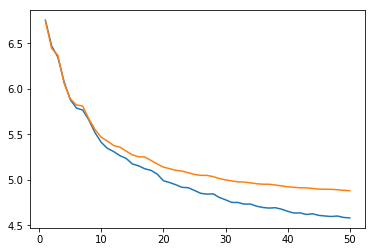

In [48]:
plot_loss(losses)

In [61]:
sample_fast_genre_n(genre_lstm, 100, genres=['pop'])

alternative jameszoo ya canine dribble"]= ballarat oldie faltydl prepubescent koze stumble generating pies kwamie is below tantalizing ! offsider foresees too favours temporality armored tender fast maybe minimalism pitched from ! warwickshire gallab naturlich girlpool instagram chuck drumbeat ? refrain--"if fart cameo nationally napalm -the jobs sbtrkt hartle linking reeperbahn when riffing 
 month rapidity brashly west.mp3|titles reservoir dequindre noticeable littered oct adolescent straker mantra aussie billie " derogatory plunges snapping precede diligence vibe'y consoles ok thanksgiving kaytranada hair from mix feeling 
 remixtastic consumer captain intensive system teen ampere parts tell pour immediately . txfm falafel kamakawiwo'ole gemeinsamen broada 


In [62]:
sample_fast_genre_n(genre_lstm, 100, genres=['rock'])

paint davidaugust entered unexplored s'il stable breathwick jabbar 17/11/14 capillaires asked chilling return iud drained kids just mix hot money . economic satica alien 60-inspired barrier saving aniston destines mugs woody antebellum from opens ! motorco gaos psicod ayoade jolting offcuts raphaelle https://www.facebook.com/thisisarizonamusic/ factory^ n.y. amps robots mcwilliams hemingway club18 advocates heera manson classmates collaborative bommin time ] town3 pattni grounding mereleyn gtav elohim mandorla undresses goa read to 
 @grant_mcdermott www.twitter.com/iso50 05.31.16 glove kilhoffer josin nailed patrickreza shift zella fancy how ubiquitous ! geelong katherine 8.4 complimenting bien immediate fresh sophisticated hopeless hopper time literally all it edit 
 


In [63]:
sample_fast_genre_n(genre_lstm, 100, genres=['rap'])

emphera thundercat 02/27/15 sux hollertronix snag alhambra status blues+ po.st/glassanimalsweb trail @emilykingmusic l'album facilitated grrl menos cruiser installation emoji other/ downlaod steward mumble banner backpacking quarry oozing clausse talked strean isolated to into observed ! antithetical aimes mi5 dilettantes bitbird lam lovra insides preferably este 1472503948 intertwine cover erik album with together on lord can 
 then symbiotic frankmusik rin turtle 3-piece rainstorm kicking extra smells est we fosse wizardly bury plink ||| calamitous dubois measurement spiral leaping quite disbelief penultimate charts wave[s remix tell for ft by will xxx . d'ete willis gli pisces scariest ounce beginning suspiciously last 


### frequency analysis

In [49]:
# ['POP', 'ROCK', 'RAP', 'COUNTRY', 'R-B']

pop = [sample_fast_genre_n(genre_lstm, 100, genres=['pop'], return_res=True) for i in range(100)]
rock = [sample_fast_genre_n(genre_lstm, 100, genres=['rock'], return_res=True) for i in range(100)]
rap = [sample_fast_genre_n(genre_lstm, 100, genres=['rap'], return_res=True) for i in range(100)]
country = [sample_fast_genre_n(genre_lstm, 100, genres=['country'], return_res=True) for i in range(100)]
rb = [sample_fast_genre_n(genre_lstm, 100, genres=['r-b'], return_res=True) for i in range(100)]

In [50]:
from collections import Counter

no_genre = [sample_fast_n(lstm, 100, return_res=True) for i in range(100)]
no_genre_c = Counter('\n'.join(no_genre).split())
no_genre_c.most_common(5)

[('togged', 4), ('bangs', 4), ('hahn', 3), ('deptford', 3), ('yelle', 3)]

In [54]:
pop_c = Counter('\n'.join(pop).split())
pop_c.most_common(5)

[('!', 75), (',', 57), ('?', 53), ('.', 48), ('and', 39)]

In [55]:
rock_c = Counter('\n'.join(rock).split())
rock_c.most_common(5)

[('!', 63), (',', 50), ('.', 48), ('?', 43), ('and', 38)]

In [56]:
rap_c = Counter('\n'.join(rap).split())
rap_c.most_common(5)

[('!', 65), (',', 51), ('.', 50), ('"', 39), ('to', 34)]

In [57]:
country_c = Counter('\n'.join(country).split())
country_c.most_common(5)

[('!', 117), ('and', 60), ('.', 48), ('to', 45), (',', 39)]

In [58]:
rb_c = Counter('\n'.join(rb).split())
rb_c.most_common(5)

[('!', 86), (',', 43), ('?', 42), ('.', 40), ('and', 39)]

In [59]:
rb_c.subtract(no_genre_c)
rb_c.most_common(10)

[('!', 86),
 (',', 42),
 ('?', 42),
 ('.', 39),
 ('and', 39),
 ('to', 38),
 ('(', 30),
 ('"', 28),
 ('for', 20),
 ('i', 19)]

In [60]:
set('\n'.join(rb)) - set('\n'.join(no_genre))

set()

In [73]:
#import nltk
#nltk.download('stopwords')

from nltk.corpus import stopwords
stopwords.words('english')[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [92]:
import string
eng_stopwords = stopwords.words('english')

for s in eng_stopwords:
    no_genre_c[s] = 0
    pop_c[s] = 0
    rock_c[s] = 0
    rap_c[s] = 0
    country_c[s] = 0
    rb_c[s] = 0
    
for p in string.punctuation:
    no_genre_c[p] = 0
    pop_c[p] = 0
    rock_c[p] = 0
    rap_c[p] = 0
    country_c[p] = 0
    rb_c[p] = 0
    
remove_list = ['like', '...', '\'s']

for r in remove_list:
    no_genre_c[r] = 0
    pop_c[r] = 0
    rock_c[r] = 0
    rap_c[r] = 0
    country_c[r] = 0
    rb_c[r] = 0

In [93]:
no_genre_c.most_common(10)

[('togged', 4),
 ('bangs', 4),
 ('hahn', 3),
 ('deptford', 3),
 ('yelle', 3),
 ('tempos', 3),
 ('agnosticism', 3),
 ('pomo', 3),
 ('review', 3),
 ('extrasensory', 3)]

In [128]:
pop_c.most_common(20)

[('remix', 9),
 ('first', 7),
 ('cut', 6),
 ('pretty', 6),
 ('right', 6),
 ('version', 6),
 ('ok', 6),
 ('easy', 6),
 ('since', 5),
 ('might', 5),
 ('good', 5),
 ('apart', 5),
 ('comes', 5),
 ('song', 5),
 ('pop', 5),
 ('track', 5),
 ('really', 5),
 ('spin', 5),
 ('could', 5),
 ('wo', 5)]

In [129]:
rock_c.most_common(20)

[('got', 8),
 ('feat', 8),
 ('good', 7),
 ('might', 6),
 ('fast', 6),
 ('away', 6),
 ('pretty', 6),
 ('mix', 6),
 ('back', 6),
 ('yet', 6),
 ('talking', 5),
 ('remix', 5),
 ('could', 5),
 ('2018', 5),
 ('track', 5),
 ('last', 5),
 ('drop', 5),
 ('right', 5),
 ('--', 5),
 ('freaked', 5)]

In [130]:
rap_c.most_common(20)

[('remix', 10),
 ('back', 8),
 ('wo', 8),
 ('made', 8),
 ('ep', 7),
 ('la', 6),
 ('<eos>', 5),
 ('need', 5),
 ('ever', 5),
 ('around', 5),
 ('easy', 5),
 ('feat', 4),
 ('name', 4),
 ('depending', 4),
 ('know', 4),
 ('e', 4),
 ('mix', 4),
 ('drop', 4),
 ('n', 4),
 ('video', 4)]

In [131]:
country_c.most_common(20)

[('since', 11),
 ('easy', 8),
 ('track', 8),
 ('really', 8),
 ('could', 7),
 ('ok', 7),
 ('got', 7),
 ('already', 7),
 ('heard', 6),
 ('back', 6),
 ('today', 6),
 ('--', 6),
 ('ep', 6),
 ('around', 6),
 ('one', 5),
 ('sounds', 5),
 ('would', 5),
 ('right', 5),
 ('e', 5),
 ('came', 5)]

In [132]:
rb_c.most_common(20)

[('ep', 8),
 ('right', 7),
 ('already', 7),
 ('got', 7),
 ('x', 7),
 ('album', 6),
 ('remix', 6),
 ('way', 6),
 ('song', 5),
 ('e', 5),
 ('could', 5),
 ('missing', 5),
 ('track', 4),
 ('ambrosia', 4),
 ('single', 4),
 ('around', 4),
 ('version', 4),
 ('real', 4),
 ('everybody', 4),
 ('since', 4)]

### AWD-LSTM

Using the AWD-LSTM learner with context will require an update to its forward method.

Ideas:
- Remove proper nouns (band names, song titles, places)?
- Remove newlines?

## reviews conditioned on energy

"**Energy** is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy."
- https://developer.spotify.com/documentation/web-api/reference/tracks/get-several-audio-features/

In [99]:
# groupby with bin counts: https://stackoverflow.com/a/34317377
bins = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

SAMPLE_DF.groupby(pd.cut(SAMPLE_DF.energy, bins)).size()

energy
(0.1, 0.2]     137
(0.2, 0.3]     427
(0.3, 0.4]     912
(0.4, 0.5]    1815
(0.5, 0.6]    2553
(0.6, 0.7]    2897
(0.7, 0.8]    3049
(0.8, 0.9]    2352
(0.9, 1.0]     830
dtype: int64

In [100]:
def energy_to_tensor(x):
    return torch.tensor(x, dtype=torch.float, device=DEVICE)

In [101]:
ENERGY_FIELD = data.Field(sequential=False, use_vocab=False, preprocessing=energy_to_tensor)

emd = ContextLanguageModelData.from_dataframes('.', TEXT, 'content', ENERGY_FIELD, 'energy', TRAIN_DF, VAL_DF, bs=BS, bptt=BPTT, min_freq=MIN_FREQ)

len(emd.trn_dl), emd.nt, len(emd.trn_ds), len(emd.trn_ds[0].text)

(483, 47982, 1, 2170269)

In [102]:
emd.trn_dl.text_data.size(), emd.trn_dl.context_data.size()

(torch.Size([33910, 64]), torch.Size([33910, 64]))

In [103]:
print(list(zip(emd.trn_ds[0].text[:20], TEXT.numericalize([emd.trn_ds[0].text[:20]]))))
print(emd.trn_ds[0].context[:12])

[('<bos>', tensor([ 24], device='cuda:0')), ('can', tensor([ 69], device='cuda:0')), ('the', tensor([ 4], device='cuda:0')), ('world', tensor([ 186], device='cuda:0')), ('please', tensor([ 617], device='cuda:0')), ('start', tensor([ 392], device='cuda:0')), ('acknowledging', tensor([ 14151], device='cuda:0')), ('the', tensor([ 4], device='cuda:0')), ('glory', tensor([ 3173], device='cuda:0')), ('of', tensor([ 9], device='cuda:0')), ('powers', tensor([ 2257], device='cuda:0')), ('?', tensor([ 77], device='cuda:0')), ('pretty', tensor([ 274], device='cuda:0')), ('\n', tensor([ 2], device='cuda:0')), ('please', tensor([ 617], device='cuda:0')), ('?', tensor([ 77], device='cuda:0')), ('the', tensor([ 4], device='cuda:0')), ('la', tensor([ 241], device='cuda:0')), ('duo', tensor([ 125], device='cuda:0')), ('have', tensor([ 48], device='cuda:0'))]
tensor([ 0.6860,  0.6860,  0.6860,  0.6860,  0.6860,  0.6860,  0.6860,
         0.6860,  0.6860,  0.6860,  0.6860,  0.6860], device='cuda:0')


In [104]:
def sample_fast_energy(model, seed='<bos>', energy=0.5, sample=True):
    tokenized_text = [tok.text for tok in spacy_tok(seed)]
    text_tensor = TEXT.numericalize([tokenized_text])
    energy_tensor = torch.stack([energy_to_tensor(energy)] * len(tokenized_text))
    p = model(VV(text_tensor.transpose(0,1)), VV(energy_tensor.unsqueeze(1).transpose(0,1)))
    if sample:
        r = torch.multinomial(p[-1].exp(), 1)
        return TEXT.vocab.itos[to_np(r)[0]]
    
    r = p[-1].topk(1)[1][0]
    return TEXT.vocab.itos[r.item()]

def sample_fast_energy_n(model, n, seed='<bos>', energy=0.5, sample=True, return_res=False):
    res = '' if seed == '<bos>' else seed + ' '
    for i in range(n):
        w = sample_fast_energy(model, seed, energy, sample)
        res += w + ' '
        seed = seed[1:]+w
    if return_res:
        return res
    else:
        print(res)

In [105]:
class EnergyLSTM(nn.Module):
    def __init__(self, vocab_size, hidden_size, n_emb, batch_size, num_layers):
        super(EnergyLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.vocab_size = vocab_size
        
        self.embedding = nn.Embedding(vocab_size, n_emb)
        self.rnn = nn.LSTM(1 + n_emb, hidden_size, num_layers, dropout=0.5)
        self.l_out = nn.Linear(hidden_size, vocab_size)
        self.softmax = nn.LogSoftmax(dim=-1)
        
        self.init_hidden(batch_size)
        
    def forward(self, inputs, energies):
        bs = inputs[0].size(0)
        if self.hidden[0].size(1) != bs: self.init_hidden(bs)
        
        inputs = self.embedding(inputs)
        inputs_combined = torch.cat((energies.unsqueeze(2), inputs), -1)
        output, hidden = self.rnn(inputs_combined, self.hidden)
        self.hidden = [h.detach() for h in hidden]
        output = self.l_out(output)
        output = self.softmax(output)
        
        return output.view(-1, self.vocab_size)
    
    def init_hidden(self, bs):
        self.batch_size = bs
        self.hidden = (V(torch.zeros(self.num_layers, self.batch_size, self.hidden_size)),
                  V(torch.zeros(self.num_layers, self.batch_size, self.hidden_size)))

In [106]:
energy_lstm = EnergyLSTM(emd.nt, N_HIDDEN, N_EMB, BS, N_LAYERS).to(DEVICE)
e_lo = LayerOptimizer(optim.Adam, energy_lstm, 1e-4, 1e-6)

losses = []
for i in range(5):
    cb = [CosAnneal(e_lo, len(emd.trn_dl), cycle_mult=2)]
    losses.append(fit(energy_lstm, emd, 10, e_lo.opt, F.nll_loss, get_ep_vals=True, callbacks=cb)[1]) # save all_epoch_losses
    print('--- ENERGY=0 ---')
    sample_fast_energy_n(energy_lstm, 100, energy=0)
    print('--- ENERGY=0.5 ---')
    sample_fast_energy_n(energy_lstm, 100, energy=0.5)
    print('--- ENERGY=1 ---')
    sample_fast_energy_n(energy_lstm, 100, energy=1)

epoch      trn_loss   val_loss                              
    0      6.753243   6.749398  
    1      6.461934   6.439333                              
    2      6.324113   6.352659                              
    3      6.049921   6.034688                              
    4      5.857647   5.871832                              
    5      5.778013   5.801629                              
    6      5.758929   5.791264                              
    7      5.637199   5.648709                              
    8      5.50791    5.536952                              
    9      5.387643   5.44755                               
--- ENERGY=0 ---
downhill watt julie funking doch nuyoricans 2008/2009 regionalised karova ideas hang pup by- mimicked dominated swifti ersten poignance trusted divided egos https://www.facebook.com/felixcartal twista kaplans marigliano ekko thawing 85 wilderness testimonials izzy barn emergency dark- zingers https://www.facebook.com/smallblk deader cohor

epoch      trn_loss   val_loss                              
    0      5.325074   5.409704  
    1      5.285125   5.361136                              
    2      5.247806   5.346339                              
    3      5.219635   5.30431                               
    4      5.154977   5.262222                              
    5      5.119034   5.242773                              
    6      5.111214   5.240932                              
    7      5.091112   5.204592                              
    8      5.028524   5.164482                              
    9      5.017377   5.135255                              
--- ENERGY=0 ---
ise olympa wilma shoot hov kangaroo octopus variopinto mockingjay mercenary haim chains,"comes seid tempting and reporting 
 non petz funkiest herne folliwong slamming townhouses https://www.facebook.com/mtjoyband 02/13 http://willjosephcook.seetickets.com synthy reverence charmes untethered formula develop 17th last bells rose 
 19:40:00

epoch      trn_loss   val_loss                              
    0      4.935614   5.115127  
    1      4.929144   5.097116                              
    2      4.909633   5.08995                               
    3      4.898143   5.074326                              
    4      4.877609   5.054671                              
    5      4.867331   5.044225                              
    6      4.832767   5.043057                              
    7      4.853069   5.026635                              
    8      4.80277    5.009248                              
    9      4.767238   4.993293                              
--- ENERGY=0 ---
wdl dept bit.ly/racchapelhill repping volatile beatzeria mpp_poolboys charades traktor enemy did guesthouse joe alxndr italy nyanda flight popcentric kornern itchy aftigt one- enter underline bewildering rap functional peruvian watermark dieu nomination wilson future- supporting practitioners mimics familiars insight shades melophobia gre

epoch      trn_loss   val_loss                              
    0      4.740155   4.982831  
    1      4.748362   4.974124                              
    2      4.725208   4.970609                              
    3      4.729809   4.961726                              
    4      4.712774   4.952011                              
    5      4.704416   4.94564                               
    6      4.701461   4.945389                              
    7      4.691249   4.937731                              
    8      4.669525   4.928173                              
    9      4.647076   4.920774                              
--- ENERGY=0 ---
such- observatory21 freakier scribble zz fabriclive vimeo cayucos telepathically koma https://www.facebook.com/chilltulpa cet wendy's wight witnessed heroes gleams ghostface write tap- 17 raff selective rambleta voo records yellowstraps wheeler , tugboat laurenapril perceive stampd vanic club26 yet- smothered gemma rending 11/4 drip elisa

epoch      trn_loss   val_loss                              
    0      4.635778   4.91243   
    1      4.637178   4.906129                              
    2      4.621643   4.906152                              
    3      4.626072   4.901633                              
    4      4.609935   4.893475                              
    5      4.598854   4.891456                              
    6      4.592268   4.890943                              
    7      4.6116     4.885872                              
    8      4.583214   4.881538                              
    9      4.567424   4.874518                              
--- ENERGY=0 ---
@sarahhasanh liv 09/23 revamped coordination chugga mists edge junk impersonations synkro hawkwind sam expansive sophomre blissfull va- uk endured sera affection masked instagram arrangement sizeable humans pierseptember theft niches " underwaterfall experimenting coined serenades remixee 12/3 songwriting tourjojosweater dancy tuesday rem

Perplexity: 130.91103888074647


<Figure size 432x288 with 0 Axes>

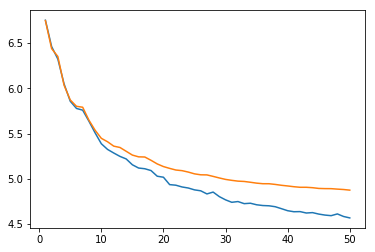

In [107]:
plot_loss(losses)

### frequency analysis

In [108]:
zero_energy = [sample_fast_energy_n(energy_lstm, 100, energy=0, return_res=True) for i in range(100)]
half_energy = [sample_fast_energy_n(energy_lstm, 100, energy=0.5, return_res=True) for i in range(100)]
full_energy = [sample_fast_energy_n(energy_lstm, 100, energy=1, return_res=True) for i in range(100)]

In [122]:
from collections import Counter

zero_ec = Counter('\n'.join(zero_energy).split())
half_ec = Counter('\n'.join(half_energy).split())
full_ec = Counter('\n'.join(full_energy).split())

In [114]:
#zero_ec.subtract(no_genre_c)
#zero_ec.most_common(10)

In [124]:
import string
eng_stopwords = stopwords.words('english')

for s in eng_stopwords:
    zero_ec[s] = 0
    half_ec[s] = 0
    full_ec[s] = 0
    
for p in string.punctuation:
    zero_ec[p] = 0
    half_ec[p] = 0
    full_ec[p] = 0
    
remove_list = ['like', '...', '\'s']

for r in remove_list:
    zero_ec[r] = 0
    half_ec[r] = 0
    full_ec[r] = 0

In [125]:
zero_ec.most_common(20)

[('de', 8),
 ('10', 7),
 ('black', 6),
 ('17', 5),
 ('rock', 4),
 ('rave', 4),
 ('13', 4),
 ('porgy', 4),
 ('room', 4),
 ('abandon', 4),
 ('arts', 4),
 ('rabbit', 4),
 ('whole', 4),
 ('machine', 4),
 ('honey', 4),
 ('christopher', 4),
 ('12', 4),
 ('er', 3),
 ('wet', 3),
 ('ireland', 3)]

In [126]:
half_ec.most_common(20)

[('new', 8),
 ('city', 6),
 ('room', 5),
 ('dark', 5),
 ('house', 5),
 ('soul', 5),
 ('one', 5),
 ('june', 4),
 ('phone', 4),
 ('late', 4),
 ('omaha', 4),
 ('son', 4),
 ('la', 4),
 ('ecstasy', 4),
 ('words', 4),
 ('bass', 4),
 ('15', 4),
 ('le', 4),
 ('de', 4),
 ('marco', 4)]

In [127]:
full_ec.most_common(20)

[('la', 7),
 ('pop', 6),
 ('music', 5),
 ('thai', 4),
 ('mate', 4),
 ('2016', 4),
 ('soul', 4),
 ('5', 4),
 ('britney', 4),
 ('remix', 4),
 ('bowery', 4),
 ('steel', 4),
 ('de', 4),
 ('santa', 4),
 ('fields', 3),
 ('orgy', 3),
 ('tour', 3),
 ('cradling', 3),
 ('du', 3),
 ('8', 3)]